Burada yapılacak işlem, bir bankanın 10bin müşterisinin bilgileriyle bir ağ eğitilip, verilen bir müşterinin bilgilerine dayanarak o müşterinin bankadan ayrılma olasığının bulunmasıdır.

### Data Preprocessing

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('data/ANN/Churn_Modelling.csv')
X = dataset.iloc[:, 3: 13].values
y = dataset.iloc[:, 13].values # 0:bankada kalır, 1:bankadan ayrılır
print(X[0],y[0])

[619 'France' 'Female' 42 2 0.0 1 1 1 101348.88] 1


In [2]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# kategorik olan 1 ve 2 indexli verileri sayısal hale getiriyoruz
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
# cinsiyeti 2 kategori olduğu için binarye çevirebiliyor.
# country ise 3 kategori olduğu için her bir kategoriyi bir özellik olarak kabul edip, ait olduğu kategoriye 1
# ait olmadıklarına ise 0 değerini veriyor.
print("Orjinal",X[0],y[0])
# bir de şöyle bir şey var. 3 ülke olduğunda şöyle oluyor ülke1:1, ülke2:0, ülke3:0
# ya böyle olsa ne farkeder ki? ülke2:0, ülke3:0
# hiç birşey farketmez aslında ülke3:1 yerine ülke2:0 ülke1:0 olmuş oluyor.
X = X[:, 1:]
print("Düzeltilmiş",X[0],y[0])

Orjinal [1.0000000e+00 0.0000000e+00 0.0000000e+00 6.1900000e+02 0.0000000e+00
 4.2000000e+01 2.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0134888e+05] 1
Düzeltilmiş [0.0000000e+00 0.0000000e+00 6.1900000e+02 0.0000000e+00 4.2000000e+01
 2.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0134888e+05] 1


In [3]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [4]:
# Feature Scaling (Normalization)
# büyük değerli özellikler küçük değerlileri domine etmesin diyie hepsini kendi aralarında bir skalaya yerleştiriyoruz
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train[0])

[-0.5698444   1.74309049  0.16958176 -1.09168714 -0.46460796  0.00666099
 -1.21571749  0.8095029   0.64259497 -1.03227043  1.10643166]


### Building the ANN

In [5]:
import keras
from keras.models import Sequential # ağı initilize etmek için gerekli
from keras.layers import Dense # katmanlar için gerekli

# init the ANN
classifier = Sequential()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


units saklı katmandaki node sayısını belirtir. Bunun net bir sayısı yoktur, tecrübe edinerek yada test ederek
karar verilir. Genellikle input ve output katmanlarındaki nodeların sayısının ortalaması alınır.<br>
input=11, output=1(binary olduğu için) (11+1)/2 = 6 seçtik.<br>
kernel_initializer, uniform fonk seçtik. uniform ağırlıkları rasgele belirler ve sıfıra yakın seçer.<br>
activation fonksiyonu olarak rectifier seçiyoruz, onu da relu olarak ekliyoruz.<br>
outputtaki activation fonksiyonu için sigmoidi seçtiğimiz görülüyor, çünkü çıkış binary olacak. Eğer birden fazla kategoride çıkış olacaksa sigmoidin çok kategorili versiyonu olan "softmax" kullanılabilir.<br>
input_dim giriş katmanında kaç tane nodun, girişin olduğunu ister. Bir kere öğrendiği için diğer saklı katmanlarda
bunu belirtmeye gerek olmayacaktır, bunu yapmasak hata verir, yaptık otomatik olarak input layeri de eklemiş olduk.

In [6]:
# input ve ilk hidden layeri ekliyoruz
classifier.add(Dense(activation = "relu", input_dim = 11, units = 6, kernel_initializer = "uniform"))
# ikinci saklı katmanı ekliyoruz, gerekli değil ama öğrenme amaçlı
classifier.add(Dense(activation = "relu", units = 6, kernel_initializer = "uniform"))
# output layeri ekliyoruz
classifier.add(Dense(activation = "sigmoid", units = 1, kernel_initializer = "uniform"))

optimizer, gradient descent ile alakalıdır. bir stochastic g.d. algoritması olan "adam"ı seçiyoruz.<br>
loss, loss fonksiyonunun yazılacağı parametredir, genellikle optimizer loss fonksiyonuna dayanır. Burada logaritmik bir loss seçmemiz gerekiyor ve outputumuz binary olduğunda "binary underscore cross entropy", eğer birden fazla kategori varsa "categorical underscore cross entropy" kullanmak gerekiyor.<br>
metrics her bir kümelemenin loss sonucunda iyileştirme yapılacak ama hangi kritere göre? işte bu metrics kriterine göre. Bu bizden kriterler listesi ister ama sadece accuracye göre yapsın istediğimiz için sadece bunu yazıyoruz şuan.

In [7]:
# compiling the ANN
classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

batch_size kümelenme sayısıdır. Yani veriyi kümelere böler ve her birinin loss sonucunu ağırlıkların güncellenmesinde kullanır.<br>
epoch ANN'nin kaç kere baştan sonra eğitileceğini belirler.<br>
Bunların ikisinin de alacağı değerleri yine tecrübelerimize dayanarak yada test ederek deneme yanılma yöntemleriyle bulabiliriz. Bu veri seti için uygun değerleri birisi bulmuş zaten, onları yazıyoruz.

In [8]:
# Fitting the ANN to the training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
8000/8000 [==============================] - 2s 225us/step - loss: 0.4720 - acc: 0.7949
Epoch 2/100
8000/8000 [==============================] - 1s 170us/step - loss: 0.4164 - acc: 0.7960
Epoch 3/100
8000/8000 [==============================] - 1s 154us/step - loss: 0.4051 - acc: 0.8207
Epoch 4/100
8000/8000 [==============================] - 1s 167us/step - loss: 0.3954 - acc: 0.8304
Epoch 5/100
8000/8000 [==============================] - 1s 187us/step - loss: 0.3875 - acc: 0.8287 1s - l
Epoch 6/100
8000/8000 [==============================] - 1s 179us/step - loss: 0.3811 - acc: 0.8375
Epoch 7/100
8000/8000 [==============================] - 2s 190us/step - loss: 0.3765 - acc: 0.8432
Epoch 8/100
8000/8000 [==============================] - 1s 179us/step - loss: 0.3731 - acc: 0.8472
Epoch 9/100
8000/8000 [==============================] - 1s 187us/step - loss: 0.3698 - acc: 0.8496
Epoch 10/100
8000/8000 [==============================] - 2s 198us/step - loss: 0.3679 - acc:

In [9]:
score = classifier.evaluate(X_test, y_test)
print("Total Accuracy: %.2f" % (score[1]))

2000/2000 [==============================] - 0s 61us/step
Total Accuracy: 0.85


### Making the Predictions and Evaluating the Model

In [10]:
# Predict the test set
y_pred = classifier.predict(X_test)
# 0.5'ten büyük değerler yerine True, öbürsülere False yazan bir yapı
y_pred_cm = (y_pred > 0.5)
# müşterilerin bankadan ayrılma ihtimalleri
for i in range(10): print(y_test[i], y_pred[i], y_pred_cm[i])
# bunları kullanarak conf matrix oluşturacağız

0 [0.30102712] [False]
1 [0.32707506] [False]
0 [0.13429971] [False]
0 [0.05475684] [False]
0 [0.06955229] [False]
1 [0.902533] [ True]
0 [0.06084306] [False]
0 [0.12900113] [False]
1 [0.26466942] [False]
1 [0.7984924] [ True]


In [11]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_cm)
print("   0      1\n0",cm[0],"\n1",cm[1])

   0      1
0 [1511   84] 
1 [209 196]


In [12]:
acc = (cm[0][0] + cm[1][1]) / 2000
print("Accuracy: %.2f" % (acc))

Accuracy: 0.85


<b>Prediction</b><br>
Şimdi bu kişinin bankadan ayrılıp ayrılmayacağını tahmin edelim.<br><br>
Geography: France<br>
Credit Score: 600<br>
Gender: Male<br>
Age: 40 years old<br>
Tenure: 3 years<br>
Balance: 60000<br>
Number of Products: 2<br>
Does this customer have a credit card ? Yes<br>
Is this customer an Active Member: Yes<br>
Estimated Salary: 50000<br>

In [13]:
# ağ 2 boyutlu dizi istiyor, bir sürü eleman var gibi işlem yapıyor
info = np.array([[0.0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]])
# normalizasyon yapıp skalaya oturtturmak lazım, sc objesi ile skala işleminde floatlar istiyor bizden
# sadece bir float sayı olması da yeterli, gerisini kendisi hallediyor
# sc objesinde train ile max min değerleri hesaplanmış bulunuyor kullanabiliriz
test = sc.transform(info)
new_prediction = classifier.predict(test)
print(new_prediction, new_prediction>0.5)

[[0.04726856]] [[False]]


### Evaluating, Improving and Tunning the ANN

<b>Cross Validation</b>

In [5]:
# sckitlearn kütüphanesi olan cross validationu keras sınıflandırıcısına uygulamak için wrappers kullanılıyor
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential # ağı initilize etmek için gerekli
from keras.layers import Dense # katmanlar için gerekli

# crossvalidation sınıflandırıcıları fonksiyon halinde istediği için ağı fonksiyon haline getiriyoruz
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(activation = "relu", input_dim = 11, units = 6, kernel_initializer = "uniform"))
    classifier.add(Dense(activation = "relu", units = 6, kernel_initializer = "uniform"))
    classifier.add(Dense(activation = "sigmoid", units = 1, kernel_initializer = "uniform"))
    classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
    return classifier

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


build_fn'ye fonksiyonumuzu vererek wrapping işleminde kullanacağımız sınıflandırıcıyı oluşturuyoruz. Yapay sinir ağını fit ederken ki gerekli bilgiler de buraya ekleniyor ki kullanabilsin.<br>
estimator, wrap edilen sınıflandırıcıyı istiyor, cv = k, (accuracies parametresi)n_jobs = -1 ise pc'de ki bütün CPU'ları kullanarak paralel işlemler yapılmasını sağlıyor böylece aynı anda birden fazla cross validation iterasyonu ve sonucu gerçekleşebilir.

In [7]:
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 50, epochs = 20)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

Epoch 1/20
7200/7200 [==============================] - 1s 129us/step - loss: 0.6355 - acc: 0.7971
Epoch 2/20
7200/7200 [==============================] - 0s 38us/step - loss: 0.4559 - acc: 0.7971
Epoch 3/20
7200/7200 [==============================] - 0s 38us/step - loss: 0.4348 - acc: 0.7971
Epoch 4/20
7200/7200 [==============================] - 0s 38us/step - loss: 0.4305 - acc: 0.7971
Epoch 5/20
7200/7200 [==============================] - 0s 38us/step - loss: 0.4277 - acc: 0.7971
Epoch 6/20
7200/7200 [==============================] - 0s 38us/step - loss: 0.4253 - acc: 0.7971
Epoch 7/20
7200/7200 [==============================] - 0s 38us/step - loss: 0.4230 - acc: 0.7971
Epoch 8/20
7200/7200 [==============================] - 0s 39us/step - loss: 0.4215 - acc: 0.7971
Epoch 9/20
7200/7200 [==============================] - 0s 39us/step - loss: 0.4198 - acc: 0.7971
Epoch 10/20
7200/7200 [==============================] - 0s 39us/step - loss: 0.4184 - acc: 0.7976
Epoch 11/20
7200/7

7200/7200 [==============================] - 1s 186us/step - loss: 0.6341 - acc: 0.7947
Epoch 2/20
7200/7200 [==============================] - 0s 41us/step - loss: 0.4657 - acc: 0.7957
Epoch 3/20
7200/7200 [==============================] - 0s 44us/step - loss: 0.4370 - acc: 0.7957
Epoch 4/20
7200/7200 [==============================] - 0s 45us/step - loss: 0.4308 - acc: 0.7957
Epoch 5/20
7200/7200 [==============================] - 0s 44us/step - loss: 0.4276 - acc: 0.7957
Epoch 6/20
7200/7200 [==============================] - 0s 43us/step - loss: 0.4254 - acc: 0.7957
Epoch 7/20
7200/7200 [==============================] - 0s 46us/step - loss: 0.4232 - acc: 0.7957
Epoch 8/20
7200/7200 [==============================] - 0s 48us/step - loss: 0.4210 - acc: 0.7957
Epoch 9/20
7200/7200 [==============================] - 0s 46us/step - loss: 0.4192 - acc: 0.7957
Epoch 10/20
7200/7200 [==============================] - 0s 42us/step - loss: 0.4176 - acc: 0.7957
Epoch 11/20
7200/7200 [======

In [8]:
mean = accuracies.mean()
variance = accuracies.std()
print(accuracies)
print(mean, variance)

[0.8325     0.82875    0.8275     0.82375    0.8475     0.83
 0.83249999 0.84374999 0.81625    0.83624999]
0.8318749953061342 0.008646710638434935


Bias modelin eğitim verisini ne kadar öğrendiğiyle alakalıdır. Model iyi öğrenmişse biası düşüktür, öğrenemiyorsa bias yüksektir. Öğrenip öğrenmediğini de accuracy'e bakarak görebiliyoruz.<br>
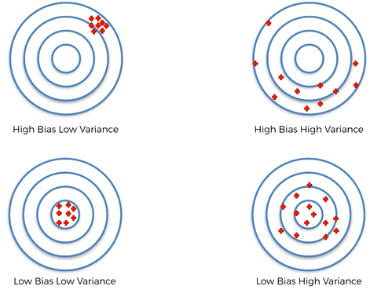

### Improving the ANN

<b>Dropout Regularization</b><br>
DR Overfitting'e çözüm olarak kullanılır. Train verisinin accuracysi yüksek ama test verisinde accuracy düşükse buna Overfitting denir. Cross Validation sonuçlarında hem yüksek hemde düşük accuracy değerleri varsa yada varyans yüksek çıkmışsa yine Overfitting olmuş demektir, yani fazla öğrenmiş. Bizim modelimize bunu uygulamaya gerek yok, Cross Validation adımlarındaki accuracylere baktığımızda birbirlerine yakın değerlerdeler(hep 0,83 civarı) ve varyans düşük ama yinede öğrenmek amaçlı uyguluyoruz.<br>
Ağ eğitilirken bazı nöronlar birbirleriyle aynı ilişkileri öğrenmesinler diye kullanım dışı kalmaları gerekir ki birbirlerinden bağımsız olsunlar da overfitting önlensin. Bunu Dropout ile yapıyoruz. Dropout bir tane layere uygulanabildiği gibi birden fazla layere de uygulanabilir. Genelde overfitting varsa emin olmak için tüm layerlere uygulanır.<br>
<br>
Dropout(rate = ?) rate değeri nöronların yüzde kaçının disable edileceğini belirtir. Yani 10 nöron varsa ve rate = 0.1 dersek 1 nöron disable olur. Overfitting çözümü için ilk önce 1 nöron disable edilir, düzelmezse arttırılarak gidilir ve gözlem yapılır. E tabi bütün nöronları disable edicek kadar da yazma, 10 nöron varsa 1.0 yazıp hepsini disable edersen bu sefer underfitting olur yani ağ hiçbir şey öğrenmez, 0.5'in üzerine çıkmamaya dikkat et.

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [13]:
classifier = Sequential()

classifier.add(Dense(activation = "relu", input_dim = 11, units = 6, kernel_initializer = "uniform"))
classifier.add(Dropout(rate = 0.1))

classifier.add(Dense(activation = "relu", units = 6, kernel_initializer = "uniform"))
classifier.add(Dropout(rate = 0.1))

classifier.add(Dense(activation = "sigmoid", units = 1, kernel_initializer = "uniform"))

classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

score = classifier.evaluate(X_test, y_test)
print("Total Accuracy: %.2f" % (score[1]))

Epoch 1/100
8000/8000 [==============================] - 3s 406us/step - loss: 0.4867 - acc: 0.7960
Epoch 2/100
8000/8000 [==============================] - 2s 222us/step - loss: 0.4350 - acc: 0.7960
Epoch 3/100
8000/8000 [==============================] - 2s 238us/step - loss: 0.4349 - acc: 0.7960
Epoch 4/100
8000/8000 [==============================] - 2s 227us/step - loss: 0.4337 - acc: 0.7960
Epoch 5/100
8000/8000 [==============================] - 2s 245us/step - loss: 0.4302 - acc: 0.7960
Epoch 6/100
8000/8000 [==============================] - 2s 239us/step - loss: 0.4302 - acc: 0.7960
Epoch 7/100
8000/8000 [==============================] - 2s 237us/step - loss: 0.4280 - acc: 0.8211
Epoch 8/100
8000/8000 [==============================] - 2s 238us/step - loss: 0.4278 - acc: 0.8246
Epoch 9/100
8000/8000 [==============================] - 2s 241us/step - loss: 0.4250 - acc: 0.8265
Epoch 10/100
8000/8000 [==============================] - 2s 247us/step - loss: 0.4230 - acc: 0.8285

### Tunning the ANN

Ağda iki tane parametre var, birisi ağırlıklar ki bunlar eğitim sırasında belirleniyor ve bunların değişimini sağlayacak back propagation şeylerini öğrendik. İkincisi hyper parametreler. Epoch sayısı, bach büyüklüğü, optimizer felan bunlar hyper parametreler ve bunlar biz tarafından belirlenir. Bunlarla oynayarak en iyi hyper parametreleri tespit edip accuracyi yükseltme işlemine de parameter tunning deniliyor. Bunun için kullanılan bir kütüphane var, Grid Search. Bu bizim yerimize parametrelerle oynayarak en iyi sonucu hangi parametreler ve parametreler kombinasyonu veriyor tespit ediyor.

In [18]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV # model_selection çalışmazsa grid_search yaz yerine
from keras.models import Sequential
from keras.layers import Dense

def build_classifier(optimizer): # bu optimizer ismi tunningde kullanılıyor, compile parametresindeki değil
    classifier = Sequential()
    classifier.add(Dense(activation = "relu", input_dim = 11, units = 6, kernel_initializer = "uniform"))
    classifier.add(Dense(activation = "relu", units = 6, kernel_initializer = "uniform"))
    classifier.add(Dense(activation = "sigmoid", units = 1, kernel_initializer = "uniform"))
    classifier.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier) # batch epoch'u gridsearch bulacak

In [19]:
# parametreleri ve bu paramatrelerin alacağı değerleri içeren bir sözlük oluşturuyoruz
# katmanlardaki parametrelerin denenmesi için model fonksiyonuna parametre yazmalı ve o parametrenin
# ismini aşağıdaki sözlüğe eklemeliyiz. Örneğin optimizere verilecek değer için optimizer parametresi ekledik
parameters = {"batch_size" : [25, 32], # 2'nin kuvvetleri genelde iyi sonuç verir
              "epochs" : [10, 20],
              "optimizer" : ["adam", "rmsprop"]}
grid_search = GridSearchCV(estimator = classifier,
                          param_grid = parameters,
                          scoring = "accuracy",
                          cv = 5)
grid_search = grid_search.fit(X_train, y_train)


Epoch 1/10
6400/6400 [==============================] - 2s 292us/step - loss: 0.5758 - acc: 0.7962
Epoch 2/10
6400/6400 [==============================] - 1s 86us/step - loss: 0.4349 - acc: 0.7980
Epoch 3/10
6400/6400 [==============================] - 1s 89us/step - loss: 0.4291 - acc: 0.7980
Epoch 4/10
6400/6400 [==============================] - 1s 86us/step - loss: 0.4264 - acc: 0.7980
Epoch 5/10
6400/6400 [==============================] - 1s 94us/step - loss: 0.4240 - acc: 0.7980
Epoch 6/10
6400/6400 [==============================] - 1s 88us/step - loss: 0.4216 - acc: 0.7980
Epoch 7/10
6400/6400 [==============================] - 1s 92us/step - loss: 0.4195 - acc: 0.7980
Epoch 8/10
6400/6400 [==============================] - 1s 102us/step - loss: 0.4178 - acc: 0.8161
Epoch 9/10
6400/6400 [==============================] - 1s 94us/step - loss: 0.4168 - acc: 0.8214
Epoch 10/10
6400/6400 [==============================] - 1s 93us/step - loss: 0.4158 - acc: 0.8242: 0s - loss: 0.418

6400/6400 [==============================] - 1s 92us/step - loss: 0.4212 - acc: 0.7973
Epoch 7/20
6400/6400 [==============================] - 1s 87us/step - loss: 0.4187 - acc: 0.7973: 0s - loss: 0.4245 - acc: 
Epoch 8/20
6400/6400 [==============================] - 1s 98us/step - loss: 0.4168 - acc: 0.8120
Epoch 9/20
6400/6400 [==============================] - 1s 95us/step - loss: 0.4154 - acc: 0.8245
Epoch 10/20
6400/6400 [==============================] - 1s 91us/step - loss: 0.4145 - acc: 0.8270
Epoch 11/20
6400/6400 [==============================] - 1s 93us/step - loss: 0.4134 - acc: 0.8287
Epoch 12/20
6400/6400 [==============================] - 1s 92us/step - loss: 0.4124 - acc: 0.8298
Epoch 13/20
6400/6400 [==============================] - 1s 92us/step - loss: 0.4113 - acc: 0.8320
Epoch 14/20
6400/6400 [==============================] - 1s 97us/step - loss: 0.4110 - acc: 0.8325
Epoch 15/20
6400/6400 [==============================] - 1s 99us/step - loss: 0.4102 - acc: 0.833

6400/6400 [==============================] - 1s 85us/step - loss: 0.4165 - acc: 0.8275
Epoch 1/10
6400/6400 [==============================] - 3s 479us/step - loss: 0.5992 - acc: 0.7967
Epoch 2/10
6400/6400 [==============================] - 1s 94us/step - loss: 0.4410 - acc: 0.7973
Epoch 3/10
6400/6400 [==============================] - 1s 87us/step - loss: 0.4315 - acc: 0.7973
Epoch 4/10
6400/6400 [==============================] - 1s 87us/step - loss: 0.4277 - acc: 0.7973
Epoch 5/10
6400/6400 [==============================] - 1s 85us/step - loss: 0.4248 - acc: 0.7973
Epoch 6/10
6400/6400 [==============================] - 1s 84us/step - loss: 0.4219 - acc: 0.7973
Epoch 7/10
6400/6400 [==============================] - 1s 85us/step - loss: 0.4197 - acc: 0.7973
Epoch 8/10
6400/6400 [==============================] - 1s 85us/step - loss: 0.4175 - acc: 0.7988
Epoch 9/10
6400/6400 [==============================] - 1s 85us/step - loss: 0.4166 - acc: 0.8189
Epoch 10/10
6400/6400 [=======

6400/6400 [==============================] - 1s 85us/step - loss: 0.4131 - acc: 0.8291
Epoch 17/20
6400/6400 [==============================] - 1s 86us/step - loss: 0.4123 - acc: 0.8306
Epoch 18/20
6400/6400 [==============================] - 1s 84us/step - loss: 0.4116 - acc: 0.8327
Epoch 19/20
6400/6400 [==============================] - 1s 86us/step - loss: 0.4111 - acc: 0.8331
Epoch 20/20
6400/6400 [==============================] - 1s 84us/step - loss: 0.4107 - acc: 0.8337
Epoch 1/20
6400/6400 [==============================] - 3s 547us/step - loss: 0.6103 - acc: 0.7959
Epoch 2/20
6400/6400 [==============================] - 1s 86us/step - loss: 0.4593 - acc: 0.7980
Epoch 3/20
6400/6400 [==============================] - 1s 92us/step - loss: 0.4371 - acc: 0.7980
Epoch 4/20
6400/6400 [==============================] - 1s 91us/step - loss: 0.4314 - acc: 0.7980
Epoch 5/20
6400/6400 [==============================] - 1s 86us/step - loss: 0.4278 - acc: 0.7980
Epoch 6/20
6400/6400 [====

NameError: name 'best_score_' is not defined

In [22]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_ # best parametrelerle elde edilen accuracy
print(best_parameters, best_accuracy)

{'batch_size': 25, 'epochs': 20, 'optimizer': 'adam'} 0.83725


ANN daha da nasıl iyileştirilebilir?
Yapısında değişiklikler yapılabilir, katmanlarda ve katmanların özelliklerinde tabiki. Paramater Tunningde daha fazla parametre denenebilir, daha çok parametre seçeneği koyulabilir. Yukarıda saatler değil de kısa sürsün diye düşük parametreler tercih ettim. %85 civarı accuracy verebilecek parametreler şunlardır:<br>
batch = 25<br>
epoch = 500<br>
optimizer = "rmsprop"